In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC, LassoLars
from sklearn.cluster import KMeans
import os

## Import Player Attributes

In [2]:
attribute_path = os.getcwd() + '/Data/Player_Attributes.csv'
attributes = pd.read_csv(attribute_path).dropna()
first_import = np.array([True if x == '2007-02-22 00:00:00' else False for x in np.array(attributes['date'].values)])
attributes = attributes[first_import]
print(attributes.columns)
f_path = os.getcwd() + '/Data/Player.csv'
players = pd.read_csv(f_path).dropna()
print(players.columns)
players.set_index('player_fifa_api_id', inplace=True)

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')
Index(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday',
       'height', 'weight'],
      dtype='object')


In [3]:
all_y = attributes['overall_rating'].values
all_x = attributes.loc[:,'crossing':'gk_reflexes'].values
attribute_names = attributes.loc[:,'crossing':'gk_reflexes'].columns.values

## Use Clustering to obtain 3 clusters and see what the results are

In [8]:
kmeans = KMeans(n_clusters=3, random_state=27).fit(all_x)
print(kmeans.cluster_centers_)

[[49.4870593  36.95679641 57.5149786  57.89993886 39.35969024 49.20440187
  45.34990829 46.70572651 53.04035052 56.93825148 64.9527206  65.73058895
  61.10271041 59.87426126 65.90279193 52.03831261 67.03281027 66.4399837
  66.00346444 42.58936214 63.2724679  58.49480334 51.77440391 54.3240269
  51.38394131 60.66415325 63.27450581 63.4485429   9.23435908 12.88689627
  34.64560831 12.96800489 12.87894844]
 [19.77666667 18.79888889 21.15222222 27.53444444 15.37444444 19.82333333
  16.21222222 30.68333333 47.62111111 24.64111111 46.45777778 46.51111111
  48.38222222 55.36444444 50.74111111 29.77555556 63.49888889 48.38333333
  59.63       17.81777778 39.36111111 37.57444444 27.32333333 36.32
  39.62333333 19.49555556 20.96222222 17.67222222 63.75666667 61.13555556
  59.75       60.84666667 65.21777778]
 [53.73517271 60.58461873 54.56658701 59.61394743 58.68020856 64.06669563
  57.22963285 52.06995438 51.03628069 64.08928959 70.31588095 70.37475559
  69.29611123 61.10862481 66.52400608 62.6

In [5]:
def attr_unpack(attributes, vals, threshold=None):
    if threshold is None:
        for attr, val in zip(attributes,vals):
            print(attr + ':\t' + str(val))
    else:
        for attr, val in zip(attributes,vals):
            if abs(val) > threshold:
                print(attr + ':\t' + str(val))
                
    return

In [9]:
attr_unpack(attribute_names, kmeans.cluster_centers_[0])

crossing:	49.48705930303651
finishing:	36.956796413286824
heading_accuracy:	57.514978601997086
short_passing:	57.899938862849154
volleys:	39.3596902384354
dribbling:	49.20440187487305
curve:	45.34990829427365
free_kick_accuracy:	46.70572651314445
long_passing:	53.04035051966593
ball_control:	56.938251477481124
acceleration:	64.95272060321983
sprint_speed:	65.73058895455473
agility:	61.10271041369459
reactions:	59.87426125942532
balance:	65.902791929896
shot_power:	52.038312614632446
jumping:	67.03281027104117
stamina:	66.43998369675936
strength:	66.00346443855695
long_shots:	42.58936213572417
aggression:	63.27246790299543
interceptions:	58.49480334216418
positioning:	51.77440391277766
vision:	54.324026900346546
penalties:	51.38394130833515
marking:	60.66415325045932
standing_tackle:	63.27450580803006
sliding_tackle:	63.44854289790164
gk_diving:	9.234359078867229
gk_handling:	12.886896270633414
gk_kicking:	34.64560831465247
gk_positioning:	12.968004890972187
gk_reflexes:	12.878948441002

## Assign Clusters, and group by clusters

In [11]:
cb = (kmeans.labels_==0)
gk = (kmeans.labels_==1)
cf = (kmeans.labels_==2)
cb_x = all_x[cb]
cb_y = all_y[cb]
gk_x = all_x[gk]
gk_y = all_y[gk]
cf_x = all_x[cf]
cf_y = all_y[cf]
print(np.sum(cb))
print(np.sum(gk))
print(np.sum(cf))

4907
900
4603


## LARS Lasso it up!

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


0.00024749951839634623 0.0004445244904444008


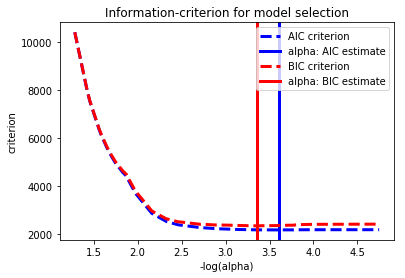

In [49]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(all_x,all_y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(all_x, all_y)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection')
print(model_aic.alpha_,model_bic.alpha_)


0.07974330973782878


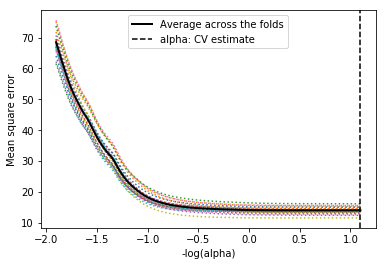

In [50]:
model = LassoCV(cv=20).fit(all_x, all_y)

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')
print(model.alpha_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


3.055390226359509e-05


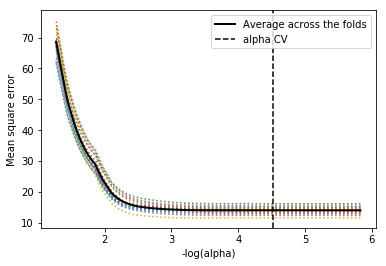

In [51]:
model = LassoLarsCV(cv=20).fit(all_x, all_y)

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')

print(model.alpha_)
plt.show()

## Train model

In [43]:
alphas = [3.055390226359509e-05,1,10,100]
alpha_source = ['bic','aic','CV','LARSCV']

models = [LassoLars(alpha=x, positive=True, fit_intercept=False) for x in alphas]
for model in models:
    model.fit(all_x,all_y)
    print(model.score(all_x,all_y))

0.7923130460879397
0.7921309583470105
0.7763257334651696
0.4956652105524906


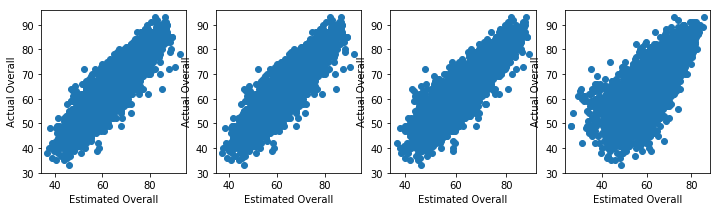

In [52]:
fig, ax = plt.subplots(1,4, figsize=(12,3))

for model, subplot in zip(models, ax):
    predict_ = model.predict(all_x)
    subplot.plot(predict_,all_y,'o')
    subplot.set_xlabel('Estimated Overall')
    subplot.set_ylabel('Actual Overall')

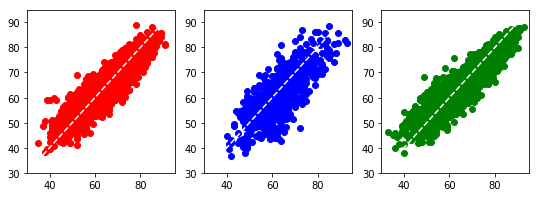

In [63]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
predict_values = models[2].predict(all_x)
ax[0].plot(all_y[cb],predict_values[cb],'ro')
ax[1].plot(all_y[gk],predict_values[gk],'bo')
ax[2].plot(all_y[cf],predict_values[cf],'go')
for subplot in ax:
    subplot.plot([30,100],[30,100],'w--')
    subplot.set_xlim([30,95])
    subplot.set_ylim([30,95])

In [64]:
attack_model = LassoLars(alpha=10, fit_intercept=False, positive=True).fit(all_x[cf],all_y[cf])
gk_model = LassoLars(alpha=10, fit_intercept=False, positive=True).fit(all_x[gk],all_y[gk])
defense_model = LassoLars(alpha=10, fit_intercept=False, positive=True).fit(all_x[cb],all_y[cb])

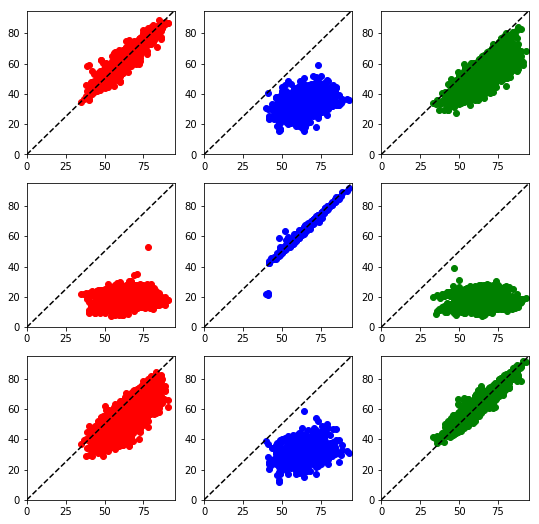

In [67]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
ax[0,0].plot(all_y[cb],defense_model.predict(all_x[cb]),'ro')
ax[0,1].plot(all_y[gk],defense_model.predict(all_x[gk]),'bo')
ax[0,2].plot(all_y[cf],defense_model.predict(all_x[cf]),'go')

ax[1,0].plot(all_y[cb],gk_model.predict(all_x[cb]),'ro')
ax[1,1].plot(all_y[gk],gk_model.predict(all_x[gk]),'bo')
ax[1,2].plot(all_y[cf],gk_model.predict(all_x[cf]),'go')

ax[2,0].plot(all_y[cb],attack_model.predict(all_x[cb]),'ro')
ax[2,1].plot(all_y[gk],attack_model.predict(all_x[gk]),'bo')
ax[2,2].plot(all_y[cf],attack_model.predict(all_x[cf]),'go')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].plot([0,100],[0,100],'k--')
        ax[i,j].set_xlim([0,95])
        ax[i,j].set_ylim([0,95])

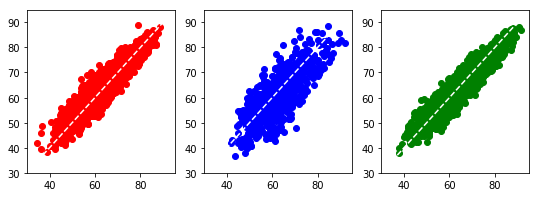

In [68]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
predict_values = models[2].predict(all_x)
ax[0].plot(defense_model.predict(all_x[cb]),predict_values[cb],'ro')
ax[1].plot(gk_model.predict(all_x[gk]),predict_values[gk],'bo')
ax[2].plot(attack_model.predict(all_x[cf]),predict_values[cf],'go')
for subplot in ax:
    subplot.plot([30,100],[30,100],'w--')
    subplot.set_xlim([30,95])
    subplot.set_ylim([30,95])

In [70]:
attr_unpack(attribute_names,attack_model.coef_,1e-3)

finishing:	0.13841441173039054
heading_accuracy:	0.026954204783703965
short_passing:	0.061466804004108026
volleys:	0.024246738210143552
dribbling:	0.1460156770278271
ball_control:	0.16925752975251435
acceleration:	0.018295137028032416
sprint_speed:	0.09410525470112105
reactions:	0.06864004113857736
shot_power:	0.0780854528358028
stamina:	0.05705618246189676
strength:	0.024893333302780315
long_shots:	0.012421360579216792
interceptions:	0.02022210328010169
positioning:	0.053773552660474365
vision:	0.023724953273601364


In [71]:
attr_unpack(attribute_names,gk_model.coef_,1e-3)

long_passing:	0.007683956861125449
sprint_speed:	0.003228594678807755
reactions:	0.02042148897056488
jumping:	0.029759679372642334
stamina:	0.005082252945631283
strength:	0.046386900118595496
gk_diving:	0.18700823218029708
gk_handling:	0.21007540827682183
gk_kicking:	0.006082007674969553
gk_positioning:	0.24466731607748352
gk_reflexes:	0.24093952104176938


In [72]:
attr_unpack(attribute_names,defense_model.coef_,1e-3)

heading_accuracy:	0.10558459117715821
short_passing:	0.06622370566267054
long_passing:	0.006912392324729507
ball_control:	0.0971802751286201
acceleration:	0.005185575199230742
sprint_speed:	0.04399748155500234
reactions:	0.05916622984885522
balance:	0.007669442354415708
jumping:	0.015010581301943614
stamina:	0.07456986264314984
strength:	0.08455488159510498
aggression:	0.025630285101173517
interceptions:	0.05044192009674722
positioning:	0.016204877616450876
penalties:	0.006198884417183145
marking:	0.11600397292252133
standing_tackle:	0.191094862225451
sliding_tackle:	0.04326285663690032


In [75]:
attr_unpack(attribute_names, models[2].coef_, 1e-3)

finishing:	0.00418869901587133
heading_accuracy:	0.08607353388603778
short_passing:	0.024328873413217926
dribbling:	0.014303559711009172
free_kick_accuracy:	0.007507138725756495
long_passing:	0.026746665450591636
ball_control:	0.15173571346735382
acceleration:	0.06561901578546052
sprint_speed:	0.09287001028258807
reactions:	0.17002637586496508
balance:	0.0069314332644154686
shot_power:	0.010056510541469103
jumping:	0.06674224619934824
stamina:	0.05306525062826293
strength:	0.11749455873099846
interceptions:	0.0321070635717424
positioning:	0.005467470968913128
penalties:	0.04140425229379862
gk_diving:	0.2532124517771866
gk_kicking:	0.026276978887695212
gk_reflexes:	0.010301274836237433


In [73]:
for model in [attack_model, gk_model, defense_model]:
    print(np.sum(model.coef_))

1.018584569819663
1.0013353581987086
1.0148944194040108
